**This notebook shows how transfer learning can be used to improve the global temperature prediction. <br/>**

By Weiwei Zhan


We train NN models using two different settings, i.e., w/o and with transfer learning, and compare how the transfer learning affects our prediction:

**w/o transfer learning:** train a NN model from scratch <br/>
**with transfer learning:** initialize the NN model with pre-trained weights that are obtained from other scenarios


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 
tf.random.set_seed(2022)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2023-11-08 16:11:59.655122: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 16:11:59.695533: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

training set: the `ssp126` scenarios <br/>
test set: the `ssp245` scenario

In [3]:
# Training set
scenario_list  = ["historical","ssp585","ssp370", "ssp126","hist-aer","hist-GHG"]
train_files    = ["ssp370"]
X_train_xr, _  = prepare_predictor(train_files,train_path)
y_train_xr, _  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### select relevant variables

predictors: CO2 & CH4 <br/>
predictand: tas

In [4]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)


y_train_df = y_train_xr["tas"].stack(dim=["latitude", "longitude"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())

#### Data standardization

In [5]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape,X_test.shape)

(86, 2) (86, 13824) (86, 2)


### 2. train & evaluate the vanilla NN w/o transfer learning

#### define & train the model

In [6]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 200
learning_rate  = 1e-4
minibatch_size = 64
model_num      = 1

In [7]:
model_vanilla = Sequential()

model_vanilla.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model_vanilla.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
model_vanilla.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
model_vanilla.add(Dense(y_train.shape[1],  activation='linear')) # the output layer


model_vanilla.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [8]:
model_vanilla.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 13824)             898560    
                                                                 
Total params: 907,072
Trainable params: 907,072
Non-trainable params: 0
_________________________________________________________________


In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model_vanilla.fit(X_train, y_train, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])



Epoch 1/200
2/2 [==============================] - 1s 194ms/step - loss: 6.1057 - val_loss: 17.0341
Epoch 2/200
2/2 [==============================] - 0s 67ms/step - loss: 6.1041 - val_loss: 17.0277
Epoch 3/200
2/2 [==============================] - 0s 23ms/step - loss: 6.1025 - val_loss: 17.0211
Epoch 4/200
2/2 [==============================] - 0s 24ms/step - loss: 6.1007 - val_loss: 17.0145
Epoch 5/200
2/2 [==============================] - 0s 23ms/step - loss: 6.0989 - val_loss: 17.0077
Epoch 6/200
2/2 [==============================] - 0s 82ms/step - loss: 6.0971 - val_loss: 17.0004
Epoch 7/200
2/2 [==============================] - 0s 23ms/step - loss: 6.0952 - val_loss: 16.9930
Epoch 8/200
2/2 [==============================] - 0s 23ms/step - loss: 6.0932 - val_loss: 16.9856
Epoch 9/200
2/2 [==============================] - 0s 24ms/step - loss: 6.0912 - val_loss: 16.9776
Epoch 10/200
2/2 [==============================] - 0s 84ms/step - loss: 6.0891 - val_loss: 16.9691
Epoch 11

#### evaluate the performance of the vanilla NN (w/o transfer learning)

In [10]:
y_pre_vanilla = model_vanilla.predict(X_test)
y_pre_vanilla = y_pre_vanilla.reshape(y_pre_vanilla.shape[0], 96, 144)

y_pre_vanilla = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                           data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_pre_vanilla)))

3/3 [==============================] - 0s 2ms/step


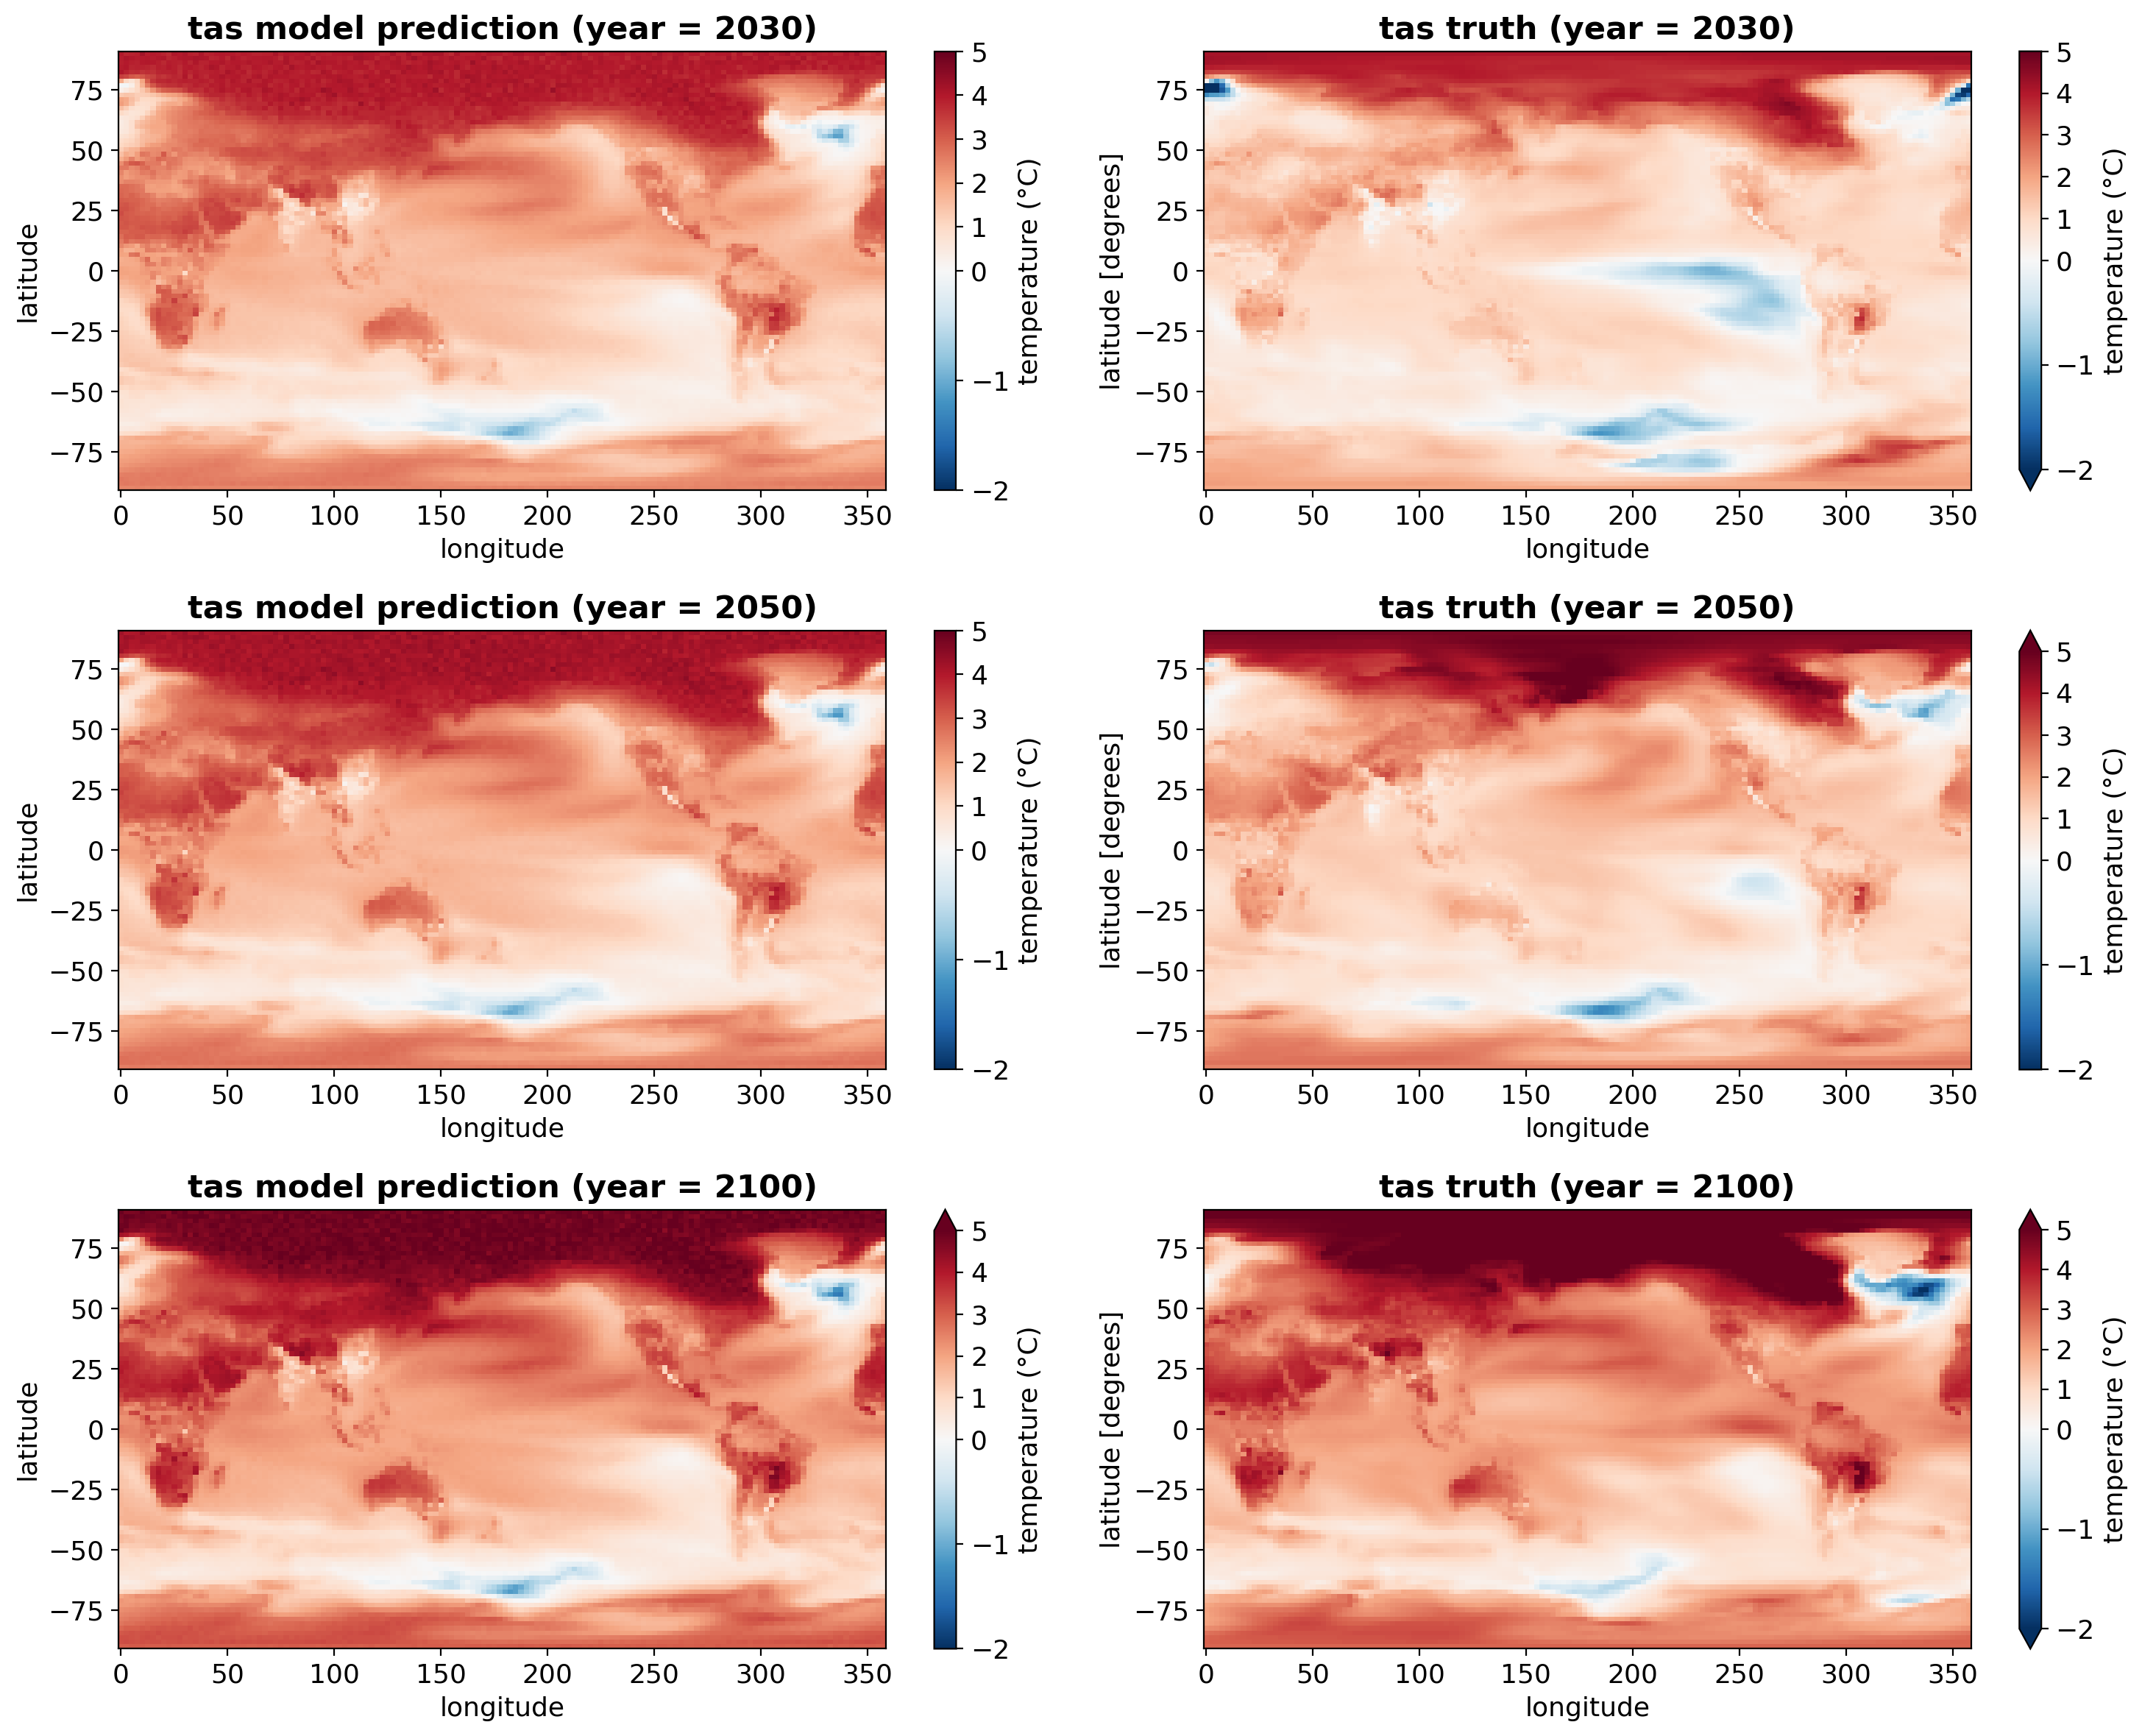

In [11]:
import matplotlib.colors as colors
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -2, 5
cmap = 'RdBu_r'
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

y_pre_vanilla.tas.sel(time=yrs[0]).plot(ax=axes[0,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})

y_pre_vanilla.tas.sel(time=yrs[1]).plot(ax=axes[1,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})

y_pre_vanilla.tas.sel(time=yrs[2]).plot(ax=axes[2,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

### 3. train NN with transfer learning

#### import a pre-trained model

The pre-trained model has the same structure but it is trained over more scenarios (`historical,ssp585,ssp126,hist-aer,hist-GHG)`

**There are two options:** we either can directly use the prepared pre-trained model by setting `use_existed_pretrain_model = True`, or we can train the pre-trained model from scratch by setting `use_existed_pretrain_model = False`.

In [12]:
use_existed_pretrain_model = False

if use_existed_pretrain_model:
    model_path = os.path.join(cwd,'saved_model')
    model_pretrain = load_model(os.path.join(model_path,'pretrained_model.h5'))
    
else:
    # Training set
    pretrain_files    = ["historical","ssp585","ssp126","hist-aer","hist-GHG"]  # "ssp370",  
    X_pretrain_xr, _  = prepare_predictor(pretrain_files,train_path)
    y_pretrain_xr, _  = prepare_predictand(pretrain_files,train_path)

    X_pretrain_df = pd.DataFrame({"CO2": X_pretrain_xr["CO2"].data,
                                  "CH4": X_pretrain_xr["CH4"].data
                              }, index=X_pretrain_xr["CO2"].coords['time'].data)
    y_pretrain_df = y_pretrain_xr["tas"].stack(dim=["latitude", "longitude"])
    y_pretrain_df = pd.DataFrame(y_pretrain_df.to_pandas())

    # Standardization
    X_pretrain_df   = (X_pretrain_df - mean)/std
    X_pretrain = X_pretrain_df.to_numpy()
    y_pretrain = y_pretrain_df.to_numpy()
    
    model_pretrain = Sequential()
    layer1=Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],),name="layer1")
    model_pretrain.add(layer1) #  the 1st hidden layer 
    layer2 = Dense(n_neuron,  activation=activation,name="layer2")
    model_pretrain.add(layer2) # the 2nd hidden layer
    layer3 = Dense(n_neuron,  activation=activation,name="layer3")
    model_pretrain.add(layer3) # the 3rd hidden layer
    layer_final = Dense(y_train.shape[1],  activation='linear',name="layerfinal")
    model_pretrain.add(layer_final) # the output layer
    model_pretrain.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    history = model_pretrain.fit(X_pretrain, y_pretrain, 
                                batch_size      = minibatch_size,
                                epochs          = num_epochs,
                                validation_split= 0.2, 
                                verbose         = 0,
                                callbacks       = [early_stop])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

#### train a NN model based on the previous pre-trained model 

In [13]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

model_pretrain.get_layer("layer1").trainable = False
model_pretrain.get_layer("layer2").trainable = False
model_pretrain.get_layer("layer3").trainable = True
model_pretrain.get_layer("layerfinal").trainable = True
    
    
history = model_pretrain.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/200
2/2 [==============================] - 0s 99ms/step - loss: 0.4311 - val_loss: 2.8372
Epoch 2/200
2/2 [==============================] - 0s 66ms/step - loss: 0.4269 - val_loss: 2.7267
Epoch 3/200
2/2 [==============================] - 0s 22ms/step - loss: 0.4186 - val_loss: 2.5712
Epoch 4/200
2/2 [==============================] - 0s 23ms/step - loss: 0.4072 - val_loss: 2.4324
Epoch 5/200
2/2 [==============================] - 0s 90ms/step - loss: 0.3962 - val_loss: 2.2952
Epoch 6/200
2/2 [==============================] - 0s 79ms/step - loss: 0.3849 - val_loss: 2.1250
Epoch 7/200
2/2 [==============================] - 0s 23ms/step - loss: 0.3750 - val_loss: 1.9556
Epoch 8/200
2/2 [==============================] - 0s 23ms/step - loss: 0.3651 - val_loss: 1.8276
Epoch 9/200
2/2 [==============================] - 0s 92ms/step - loss: 0.3572 - val_loss: 1.7309
Epoch 10/200
2/2 [==============================] - 0s 74ms/step - loss: 0.3506 - val_loss: 1.6469
Epoch 11/200
2/2 [=

In [14]:
y_pre_tl = model_pretrain.predict(X_test)
y_pre_tl = y_pre_tl.reshape(y_pre_tl.shape[0], 96, 144)

y_pre_tl = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_pre_tl)))

3/3 [==============================] - 0s 2ms/step


### compare the prediction with v.s. w/o transfer learning

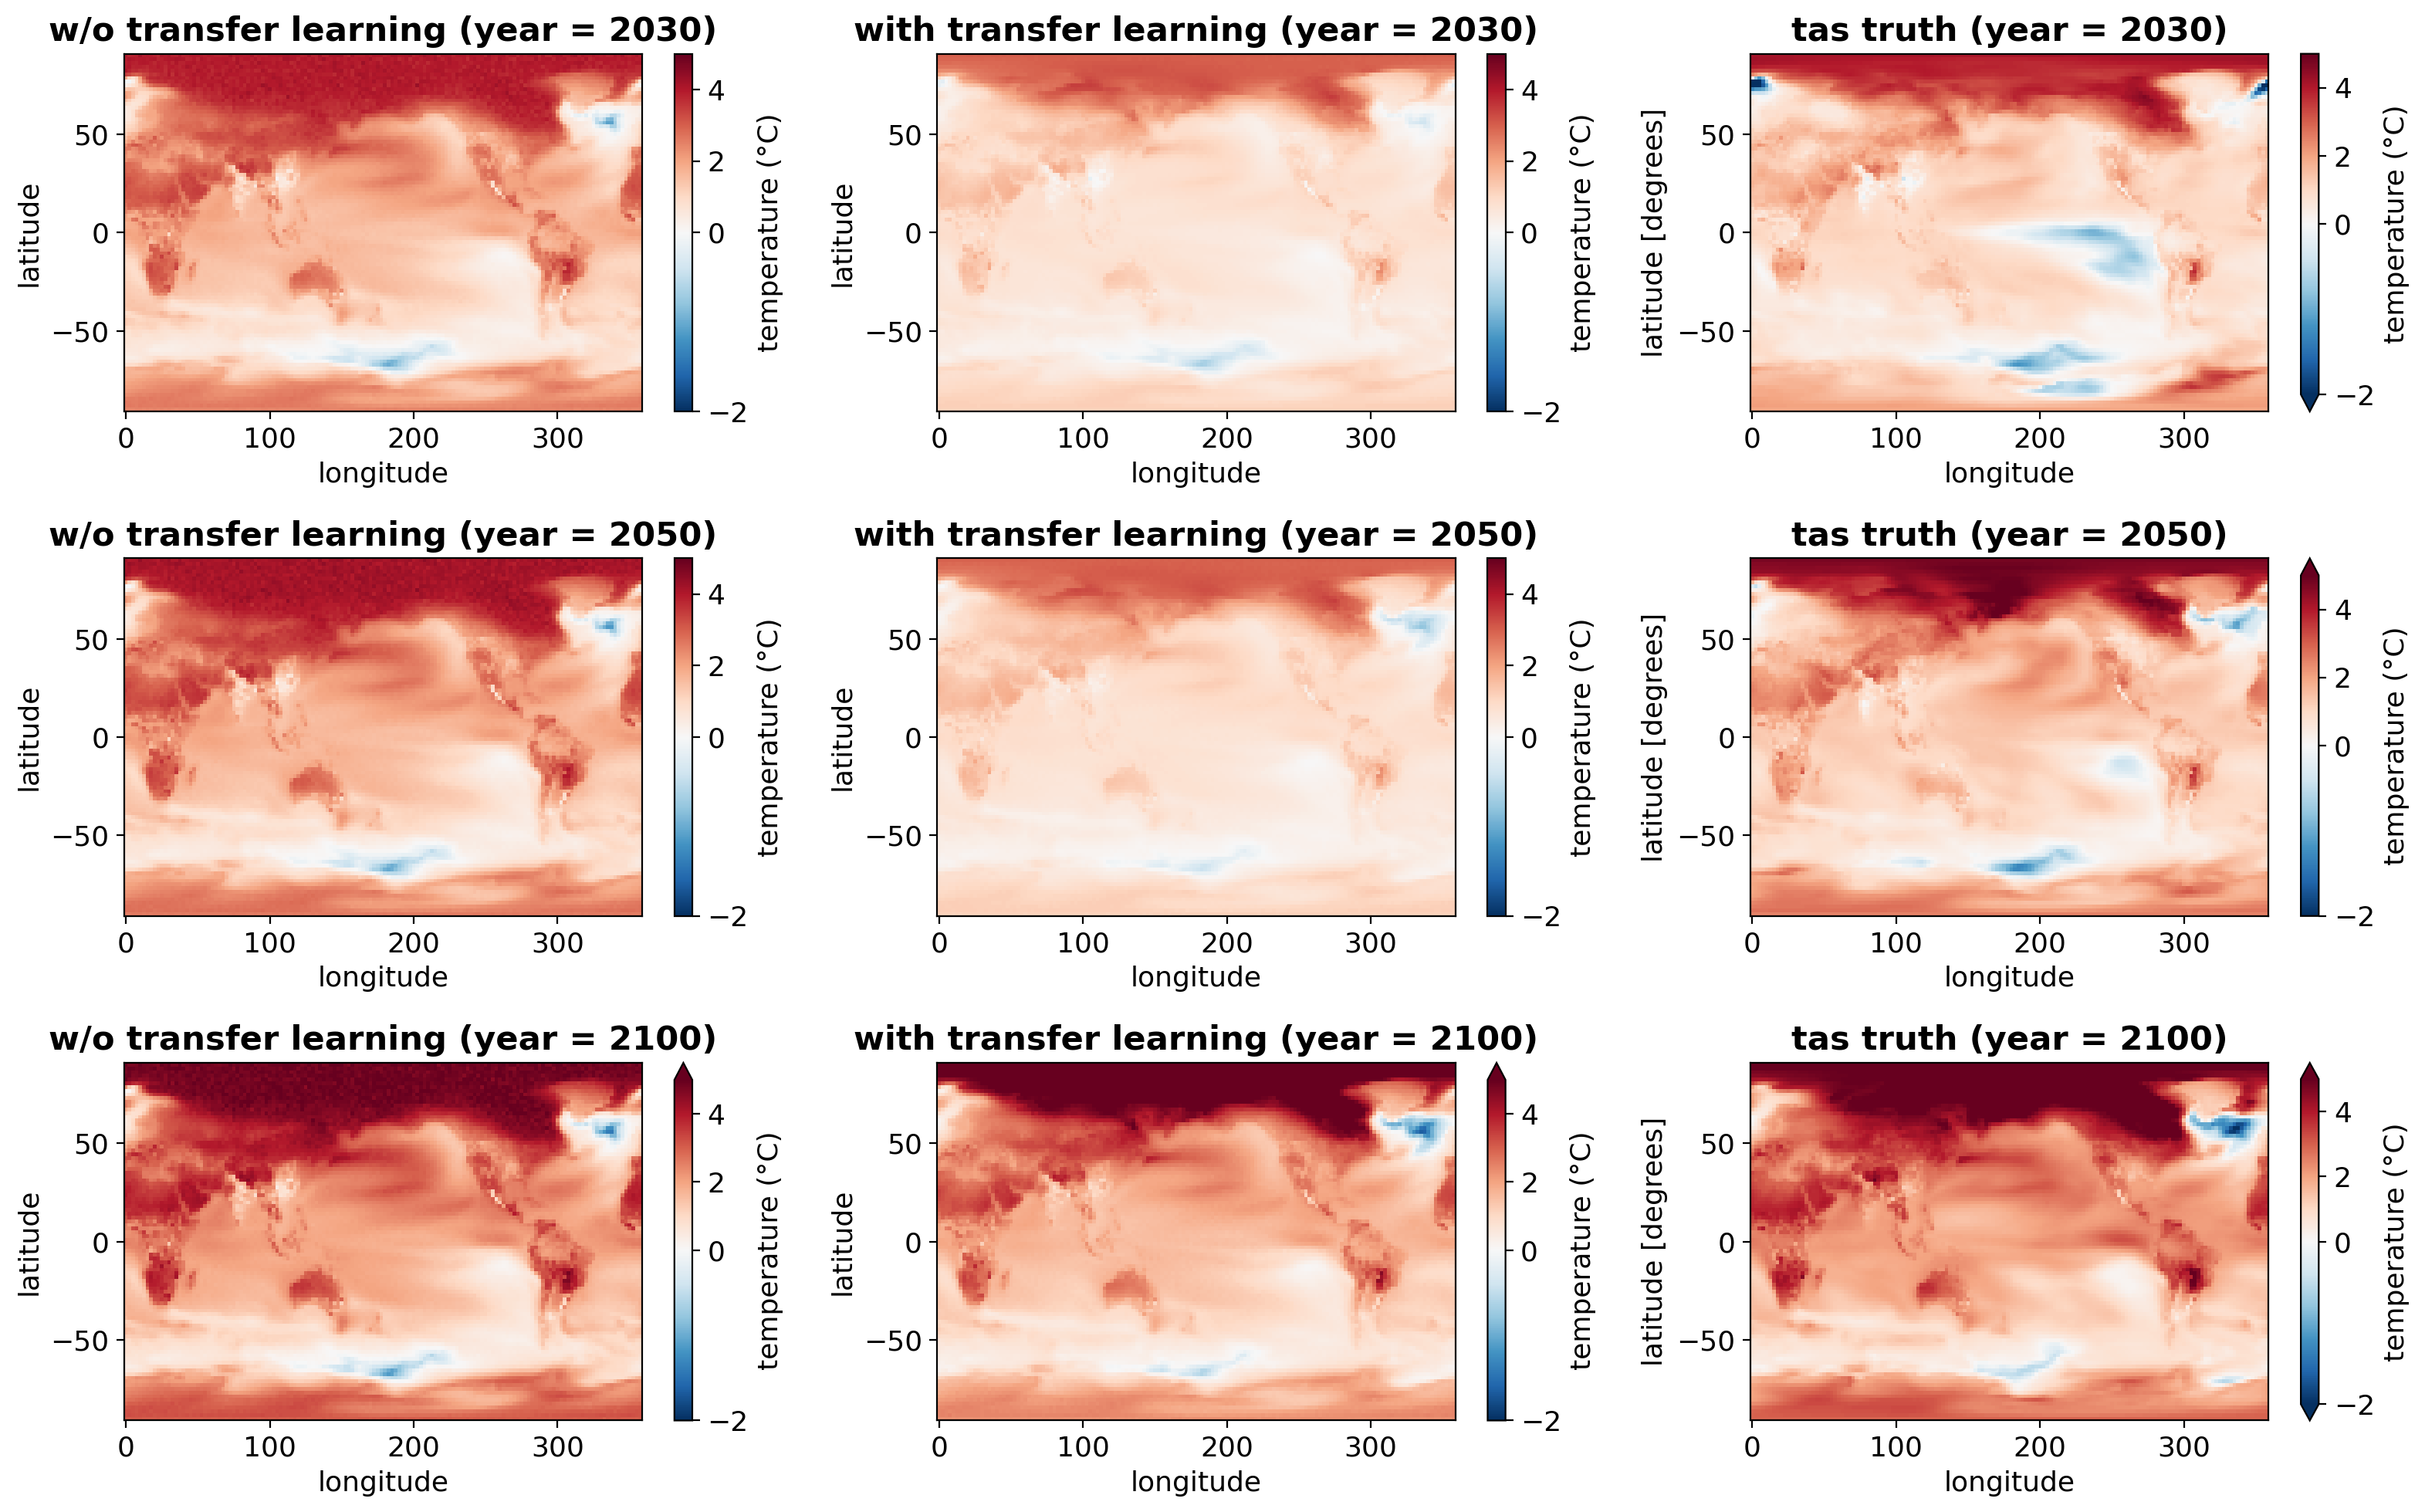

In [15]:
fig, axes = plt.subplots(figsize=(16,10),ncols=3,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -2, 5
cmap = 'RdBu_r'
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

y_pre_vanilla.tas.sel(time=yrs[0]).plot(ax=axes[0,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_pre_tl.tas.sel(time=yrs[0]).plot(ax=axes[0,1], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,2], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})

y_pre_vanilla.tas.sel(time=yrs[1]).plot(ax=axes[1,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_pre_tl.tas.sel(time=yrs[1]).plot(ax=axes[1,1], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,2], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})

y_pre_vanilla.tas.sel(time=yrs[2]).plot(ax=axes[2,0], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_pre_tl.tas.sel(time=yrs[2]).plot(ax=axes[2,1], cmap=cmap,norm=divnorm, 
                                          cbar_kwargs={"label":"temperature (°C)"})
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,2], cmap=cmap,norm=divnorm, 
                                    cbar_kwargs={"label":"temperature (°C)"})


for i, ax in enumerate(axes.flat):
    # left column: model prediction without transfer learning
    if i % 3 == 0:
        ax.set_title(f'w/o transfer learning (year = {yrs[i//3]})',fontweight='bold')
        
    # middle column: model prediction with transfer learning
    elif i % 3 == 1:
        ax.set_title(f'with transfer learning (year = {yrs[i//3]})',fontweight='bold')
    
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//3]})',fontweight='bold')


plt.tight_layout()

Then we also check whether the ML model can reproduce the time series of a given location.<br/> Here we take NYC as an example (40.7128° N, 74.0060° W)

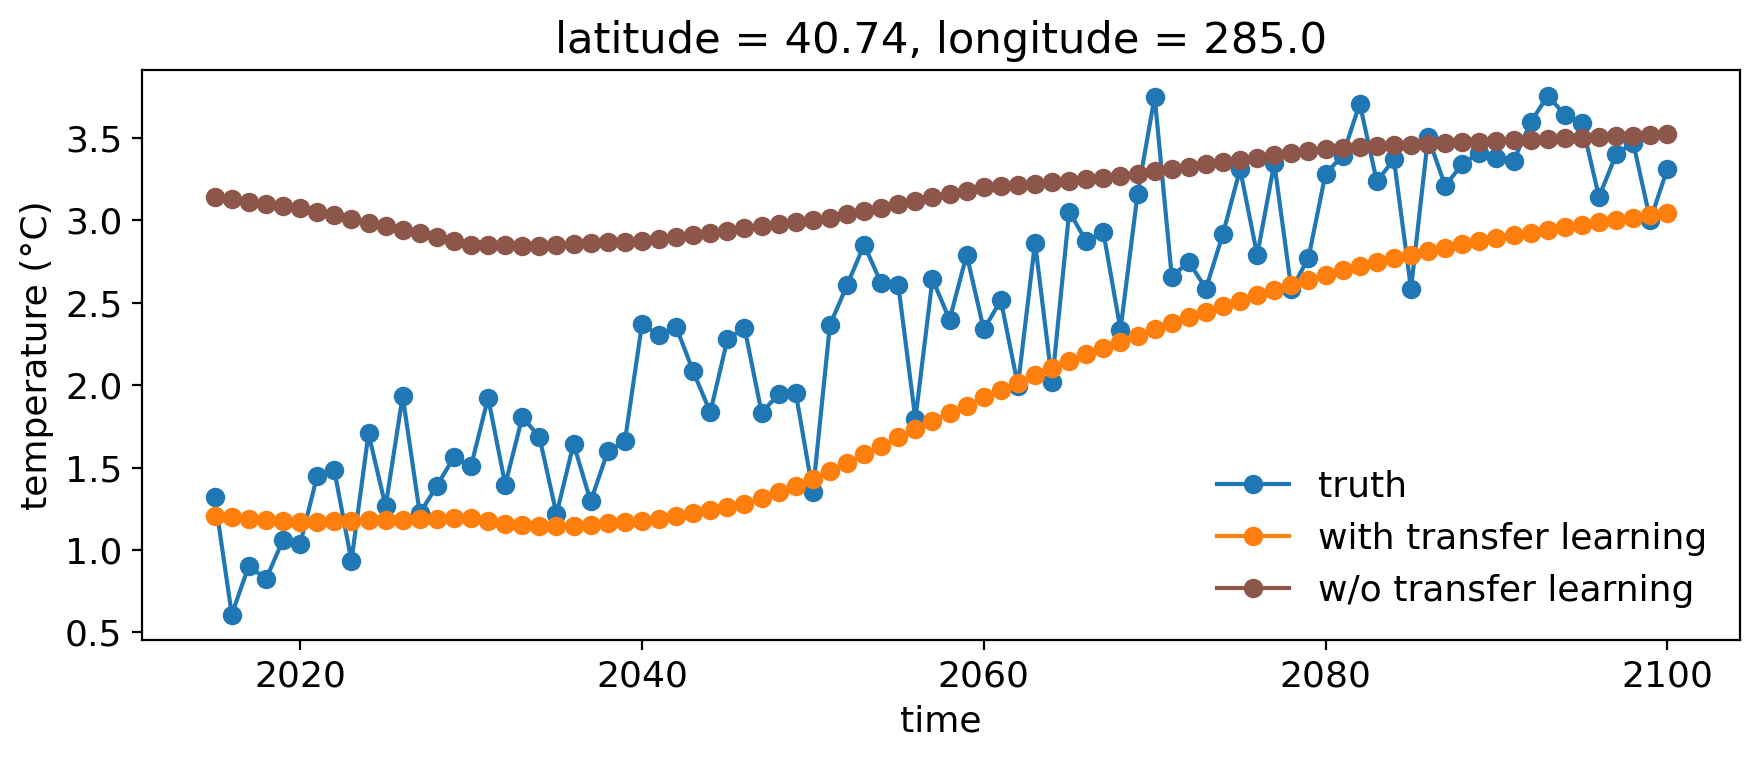

In [17]:
lat = 40.7128
lon = -74.0060%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,color='tab:blue',label='truth')
y_pre_tl.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,color='tab:orange',label='with transfer learning')
y_pre_vanilla.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,color='tab:brown',label='w/o transfer learning')

ax.legend()
ax.set_ylabel('temperature (°C)')

plt.tight_layout()